In [12]:
# Generate Grutl-nbfnet_heat_map.csv
import sqlite3
import pandas as pd
import os

# Define file paths
GRUTL_DB_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results_all_to_all.db"
NBFNET_DB_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/result.db"
OUTPUT_CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_heatmap.csv"

# List of datasets and checkpoints to filter
DATASETS = ["Epinions", "LastFM", "BookX", "Ml1m"]
CKPT_LIST = ["Epinions.pth", "LastFM.pth", "BookX.pth", "Ml1m.pth"]

# Function to extract 0-shot results from a given database
def extract_zero_shot_results(db_file, table_name, model_name):
    with sqlite3.connect(db_file) as conn:
        df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

    # Filter for 0-shot settings
    df_filtered = df[
        (df['dataset'].isin(DATASETS)) &
        (df['ckpt'].isin(CKPT_LIST)) &
        (df['epochs'] == 0)
    ].copy()

    # Remove 'id' column if it exists
    if 'id' in df_filtered.columns:
        df_filtered = df_filtered.drop(columns=['id'])

    # Add model column
    df_filtered["model"] = model_name

    return df_filtered

# Extract data from GRUTL and NBFNet databases
df_grutl = extract_zero_shot_results(GRUTL_DB_FILE, "experiments", "GRUTL")
df_nbfnet = extract_zero_shot_results(NBFNET_DB_FILE, "results", "NBFNet")

# Combine the filtered data from both models
df_final = pd.concat([df_grutl, df_nbfnet], ignore_index=True)

# Ensure output directory exists
os.makedirs(os.path.dirname(OUTPUT_CSV_FILE), exist_ok=True)

# Save the final DataFrame to CSV
df_final.to_csv(OUTPUT_CSV_FILE, index=False)

print(f"CSV file saved at: {OUTPUT_CSV_FILE}")


CSV file saved at: /itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_heatmap.csv


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# File paths
csv_path = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_heatmap.csv"
plot_path = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_heatmap.png"

# Load the CSV file
df = pd.read_csv(csv_path)

# Define datasets and checkpoints
DATASETS = ["Epinions", "LastFM", "BookX", "Ml1m"]
CKPT_LIST = ["Epinions.pth", "LastFM.pth", "BookX.pth", "Ml1m.pth"]

# Rename "Ml1m" -> "ML-1M" for both dataset and checkpoint
df["dataset"] = df["dataset"].replace({"Ml1m": "ML-1M"})
df["ckpt"] = df["ckpt"].replace({"Ml1m.pth": "ML-1M"})  # Ensure checkpoints match datasets

# Add postfix to dataset names to differentiate models
df["dataset"] = df.apply(lambda row: f"{row['dataset']} (G)" if row["model"] == "GRUTL" else f"{row['dataset']} (N)", axis=1)

# Remove ".pth" from checkpoint names for readability
df["ckpt"] = df["ckpt"].str.replace(".pth", "", regex=False)

# Select the correct metric
def get_target_metric(row):
    return row["test_ndcg@20"] if any(ds in row["dataset"] for ds in ["Gowalla", "Yelp18"]) else row["test_hits@10"]

df["target_metric"] = df.apply(get_target_metric, axis=1)

# Normalize target_metric per dataset
df["normalized_target_metric"] = df.groupby("dataset")["target_metric"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

# Ensure correct ordering: each dataset should be followed by its corresponding model
desired_order = []
for ds in ["Epinions", "LastFM", "BookX", "ML-1M"]:
    desired_order.extend([f"{ds} (G)", f"{ds} (N)"])  # Ensuring GRUTL appears before NBFNet

# Reverse the y-axis order (checkpoints should remain reversed)
reversed_order = list(reversed(["Epinions", "LastFM", "BookX", "ML-1M"]))

# Pivot DataFrame again with the fixed names and ordering
pivot_original = df.pivot(index="ckpt", columns="dataset", values="target_metric")
pivot_normalized = df.pivot(index="ckpt", columns="dataset", values="normalized_target_metric")

# Apply proper ordering
pivot_original = pivot_original.reindex(index=reversed_order, columns=desired_order)
pivot_normalized = pivot_normalized.reindex(index=reversed_order, columns=desired_order)

# Function to plot the corrected heatmap
def plot_corrected_heatmap():
    plt.figure(figsize=(8, 8))  # Keeping it square
    ax = sns.heatmap(
        pivot_normalized, annot=pivot_original, fmt=".3f", cmap="Blues",
        linewidths=0.7, linecolor="gray", cbar_kws={'label': 'Normalized Score'},
        annot_kws={"size": 10}, vmin=0, vmax=1
    )

    # Improve labels
    plt.title("GRUTL vs NBFNet: 0-Shot Normalized Performance Heatmap", fontsize=14)
    plt.xlabel("Dataset (Model)", fontsize=12, labelpad=10)
    plt.ylabel("Checkpoint", fontsize=12, labelpad=10)
    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Ensure the directory exists
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    # Save the heatmap
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()

    #plt.show()

# Call the function to visualize the corrected heatmap
plot_corrected_heatmap()


In [5]:
# Generate Grutl-nbfnet_summary.csv
import sqlite3
import pandas as pd
import os

# Define file paths
GRUTL_DB_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results.db"
NBFNET_DB_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/result.db"
OUTPUT_CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_summary.csv"

# List of datasets
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m"]

# --- Extract GRUTL Model Results ---
with sqlite3.connect(GRUTL_DB_FILE) as conn:
    df_grutl = pd.read_sql("SELECT * FROM experiments", conn)

# Prepare list for GRUTL results
grutl_rows = []

for ds in DATASETS:
    # --- SOTA ---
    df_sota = df_grutl[(df_grutl['dataset'] == ds) & (df_grutl['ckpt'] == 'SOTA')]
    if not df_sota.empty:
        row = df_sota.iloc[0].copy()
        row['setting'] = 'SOTA'
        row['model'] = 'SOTA'
        grutl_rows.append(row)

    # --- End-to-End (ETE) ---
    df_ete = df_grutl[(df_grutl['dataset'] == ds) & (df_grutl['ckpt'] == 'ETE')]
    if not df_ete.empty:
        row = df_ete.iloc[0].copy()
        row['setting'] = 'End-to-End'
        row['model'] = 'GRUTL'
        grutl_rows.append(row)

    # --- 0-shot ---
    df_zero_shot = df_grutl[(df_grutl['dataset'] == ds) & (df_grutl['ckpt'] == 'Beau_Epin.pth') & (df_grutl['epochs'] == 0)]
    if not df_zero_shot.empty:
        row = df_zero_shot.iloc[0].copy()
        row['setting'] = '0-shot'
        row['model'] = 'GRUTL'
        grutl_rows.append(row)

    # --- FT ---
    df_ft = df_grutl[(df_grutl['dataset'] == ds) & (df_grutl['ckpt'] == 'Beau_Epin.pth') & (df_grutl['epochs'] == 1)]
    if not df_ft.empty:
        row = df_ft.iloc[0].copy()
        row['setting'] = 'FT'
        row['model'] = 'GRUTL'
        grutl_rows.append(row)

# Convert to DataFrame
df_grutl_report = pd.DataFrame(grutl_rows)

# --- Extract NBFNet Model Results ---
with sqlite3.connect(NBFNET_DB_FILE) as conn:
    df_nbfnet = pd.read_sql("SELECT * FROM results", conn)

# Prepare list for NBFNet results
nbfnet_rows = []

for ds in DATASETS:
    # --- End-to-End (ETE) ---
    df_ete = df_nbfnet[(df_nbfnet['dataset'] == ds) & (df_nbfnet['ckpt'] == 'ETE')]
    if not df_ete.empty:
        row = df_ete.iloc[0].copy()
        row['setting'] = 'End-to-End'
        row['model'] = 'NBFNet'
        nbfnet_rows.append(row)

    # --- 0-shot ---
    df_zero_shot = df_nbfnet[(df_nbfnet['dataset'] == ds) & (df_nbfnet['ckpt'] == 'Beau_Epin.pth') & (df_nbfnet['epochs'] == 0)]
    if not df_zero_shot.empty:
        row = df_zero_shot.iloc[0].copy()
        row['setting'] = '0-shot'
        row['model'] = 'NBFNet'
        nbfnet_rows.append(row)

    # --- FT ---
    df_ft = df_nbfnet[(df_nbfnet['dataset'] == ds) & (df_nbfnet['ckpt'] == 'Beau_Epin.pth') & (df_nbfnet['epochs'] == 1)]
    if not df_ft.empty:
        row = df_ft.iloc[0].copy()
        row['setting'] = 'FT'
        row['model'] = 'NBFNet'
        nbfnet_rows.append(row)

# Convert to DataFrame
df_nbfnet_report = pd.DataFrame(nbfnet_rows)

# Combine both reports
df_final = pd.concat([df_grutl_report, df_nbfnet_report], ignore_index=True)

# Ensure columns are properly ordered
columns = ['dataset', 'setting', 'model'] + [col for col in df_final.columns if col not in ['dataset', 'setting', 'model']]
df_final = df_final[columns]

# Ensure output directory exists
os.makedirs(os.path.dirname(OUTPUT_CSV_FILE), exist_ok=True)

# Save to CSV
df_final.to_csv(OUTPUT_CSV_FILE, index=False)

print(f"Final report saved to {OUTPUT_CSV_FILE}")


Final report saved to /itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_summary.csv


In [10]:
# Generate Grutl-nbfnet_summary plot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
csv_path = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_summary.csv"
plot_path = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_summary.png"

# Load the CSV file
df = pd.read_csv(csv_path)

# Use a serif font for better LaTeX compatibility
plt.rcParams["font.family"] = "serif"

# List of datasets to include in the plot
DATASETS = ["Epinions", "LastFM", "BookX", "Ml1m"]

# Rename dataset labels
def rename_dataset(name):
    return "ML-1M" if name == "Ml1m" else name

df["dataset"] = df["dataset"].apply(rename_dataset)


# Define dataset order for consistent visualization
desired_order = ["Epinions", "ML-1M", "LastFM", "BookX"]
df["dataset"] = pd.Categorical(df["dataset"], categories=desired_order, ordered=True)
df = df.sort_values("dataset")

# Define settings order
settings_order = ['SOTA', 'End-to-End', 'FT', '0-shot']

# Define colors: use predefined colors for SOTA and GRUTL, violet-pinkish for NBFNet
colors = {
    'SOTA': '#FFA07A',  # Light orange
    'End-to-End (GRUTL)': '#1E90FF',  # Dodger blue
    'FT (GRUTL)': '#4682B4',  # Steel blue
    '0-shot (GRUTL)': '#87CEFA',  # Light sky blue
    'End-to-End (NBFNet)': '#DA70D6',  # Orchid
    'FT (NBFNet)': '#C71585',  # Medium violet-red
    '0-shot (NBFNet)': '#DB7093'  # Pale violet-red
}

# Extract metric values per dataset and setting
metric_by_ds = {}
for ds in desired_order:
    metric_col = "test_ndcg@20" if ds in ["Gowalla", "Yelp18"] else "test_hits@10"
    metric_by_ds[ds] = {'metric_col': metric_col, 'values': {}}
    for setting in settings_order:
        if setting == "SOTA":
            row = df[(df['dataset'] == ds) & (df['setting'] == setting)]
            value = row.iloc[0][metric_col] if not row.empty else np.nan
            key = f"{setting}"
            metric_by_ds[ds]['values'][key] = value
        else:
            for model in ["GRUTL", "NBFNet"]:
                row = df[(df['dataset'] == ds) & (df['setting'] == setting) & (df['model'] == model)]
                value = row.iloc[0][metric_col] if not row.empty else np.nan
                key = f"{setting} ({model})"
                metric_by_ds[ds]['values'][key] = value

# Prepare plotting parameters
n_datasets = len(desired_order)
n_settings = len(settings_order) + 2  # Since we have SOTA and two models
bar_width = 0.1
x = np.arange(n_datasets) * (n_settings * bar_width + 0.3)  # Add spacing between datasets

# Create the plot
plt.figure(figsize=(14, 8))
for i, key in enumerate(colors.keys()):
    offset = i * bar_width
    values = [metric_by_ds[ds]['values'].get(key, np.nan) for ds in desired_order]
    plt.bar(x + offset, values, width=bar_width, color=colors[key], label=key, edgecolor='black')

# Update x-axis labels
plt.xticks(x + (n_settings / 2 - 0.5) * bar_width, desired_order, rotation=30, ha='right', fontsize=12)
plt.xlabel("Datasets", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.title("Performance Comparison: GRUTL vs NBFNet", fontsize=18)
plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)
plt.legend(title="Setting", fontsize=12)
plt.tight_layout()

# Ensure the directory exists
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
#plt.show()
# Save the plot
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Plot saved to {plot_path}")

Plot saved to /itet-stor/trachsele/net_scratch/tl4rec/report_data/Grutl-nbfnet_summary.png


In [ ]:
import os
import pandas as pd
import torch
from ultra import datasets
# Snippet for generating statistics about the datasets
# List of dataset names
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m", "Gowalla",
    "Amazon_Beauty", "Amazon_Fashion", "Amazon_Men", "Amazon_Games", "Yelp18"
]

# Root folder for the data
DATA_ROOT = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/data"

results = []

for ds in DATASETS:
    print(f"Processing dataset: {ds}")
    # Dynamically load the dataset class from ultra.datasets
    dataset_class = getattr(datasets, ds)
    dataset = dataset_class(root=DATA_ROOT)
    
    # Load train, valid, test PyG Data objects.
    train_data, valid_data, test_data = dataset[0], dataset[1], dataset[2]
    
    # Compute the number of directed edges from target_edge_index (for train and test)
    num_train_edges = train_data.target_edge_index.size(1)
    num_test_edges = test_data.target_edge_index.size(1)
    num_valid_edges = valid_data.target_edge_index.size(1)
    
    # Try to get the number of users and items from the dataset.
    # (Adjust this if your datasets store this information differently.)
    try:
        num_users = dataset.num_users
        num_items = dataset.num_items
    except AttributeError:
        # Fallback: if not available, set to None (or infer from the graph if possible)
        num_users = None
        num_items = None

    # Compute average degrees if num_users and num_items are known.
    if num_users is not None and num_items is not None:
        avg_user_degree_train = num_train_edges / num_users
        avg_item_degree_train = num_train_edges / num_items
        avg_user_degree_test  = num_test_edges / num_users
        avg_item_degree_test  = num_test_edges / num_items
        overall_density = (num_train_edges + num_test_edges +  num_valid_edges) / (num_users * num_items)
    else:
        avg_user_degree_train = avg_item_degree_train = None
        avg_user_degree_test = avg_item_degree_test = None
        overall_density = None

    # Get the dimension of edge attributes (from the train graph's edge_attr)
    if hasattr(train_data, 'edge_attr') and train_data.edge_attr is not None:
        edge_attr_dim = train_data.edge_attr.size(1)
    else:
        edge_attr_dim = None

    # Define the meaning of the edge attributes based on dataset name
    if ds == "Yelp18":
        edge_attr_meaning = "rating, date, useful, funny, cool"
    elif ds == "Gowalla":
        edge_attr_meaning = "Date, longitude, latitude"
    elif ds.startswith("Amazon_"):
        edge_attr_meaning = "context (already processed)"
    elif ds == "Ml1m":
        edge_attr_meaning = "rating and timestamp"
    elif ds == "BookX":
        edge_attr_meaning = "rating"
    elif ds == "LastFM":
        edge_attr_meaning = "listening count"
    elif ds == "Epinions":
        edge_attr_meaning = "categoryid, rating, helpfulness and time point"
    else:
        edge_attr_meaning = "unknown"

    results.append({
        "dataset": ds,
        "number_of_edges_train": num_train_edges,
        "number_of_edges_test": num_test_edges,
        "num_users": num_users,
        "num_items": num_items,
        "average_user_degree_train": avg_user_degree_train,
        "average_user_degree_test": avg_user_degree_test,
        "average_item_degree_train": avg_item_degree_train,
        "average_item_degree_test": avg_item_degree_test,
        "overall_density": overall_density,
        "edge_attr_dim": edge_attr_dim,
        "meaning_of_edge_attributes": edge_attr_meaning
    })

# Create a DataFrame from the collected statistics and save it as a CSV file.
df_results = pd.DataFrame(results)
print (df_results)
#output_csv = "graph_dataset_statistics.csv"
#df_results.to_csv(output_csv, index=False)
#print(f"Dataset statistics saved to {output_csv}")


In [6]:
import pandas as pd

# Load the dataset
file_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/Dataset_Statistics.csv'
df = pd.read_csv(file_path)

# Rename datasets
df['dataset'] = df['dataset'].replace({'Ml1m': 'ML-1M'})
df['dataset'] = df['dataset'].str.replace(r'^Amazon_(\w+)', r'Amazon \1', regex=True)

# Save the modified dataset
output_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/Dataset_Statistics_1.csv'
df.to_csv(output_path, index=False)
print ("done")


done


In [2]:
import sqlite3
import pandas as pd
import os

# Define the file path to save the resulting CSV
file_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/ete_sota_0_shot_ft_updated.csv'

# Connect to the database and load the experiments table
DB_FILE = '/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results.db'
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql("SELECT * FROM experiments", conn)
conn.close()

# List of datasets
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m", "Gowalla",
    "Amazon_Beauty", "Amazon_Fashion", "Amazon_Men", "Amazon_Games", "Yelp18"
]

# Prepare a list to collect the rows for the report
report_rows = []

for ds in DATASETS:
    # --- SOTA ---
    df_sota = df[(df['dataset'] == ds) & (df['ckpt'] == 'SOTA')]
    if not df_sota.empty:
        row = df_sota.iloc[0].copy()
        row['setting'] = 'SOTA'
        report_rows.append(row)
    else:
        print(f"No SOTA row found for dataset {ds}")

    # --- End-to-End (ETE) ---
    # Select where ckpt == 'ETE' for the given dataset
    df_ete = df[(df['dataset'] == ds) & (df['ckpt'] == 'ETE')]
    if not df_ete.empty:
        row = df_ete.iloc[0].copy()
        row['setting'] = 'End-to-End'  # Update setting to "End-to-End"
        report_rows.append(row)
    else:
        print(f"No End-to-End row found for dataset {ds}")

    # --- 0-shot ---
    df_zero_shot = df[(df['dataset'] == ds) & (df['ckpt'] == 'Beau_Epin.pth') & (df['epochs'] == 0)]
    if not df_zero_shot.empty:
        row = df_zero_shot.iloc[0].copy()
        row['setting'] = '0-shot'
        report_rows.append(row)
    else:
        print(f"No 0-shot row found for dataset {ds}")

    # --- FT ---
    df_ft = df[(df['dataset'] == ds) & (df['ckpt'] == 'Beau_Epin.pth') & (df['epochs'] == 1)]
    if not df_ft.empty:
        row = df_ft.iloc[0].copy()
        row['setting'] = 'FT'
        report_rows.append(row)
    else:
        print(f"No FT row found for dataset {ds}")

# Combine all collected rows into a new DataFrame
df_report = pd.DataFrame(report_rows)

# (Optional) Rearrange columns to have dataset and setting at the front
cols = df_report.columns.tolist()
for col in ['dataset', 'setting']:
    cols.remove(col)
df_report = df_report[['dataset', 'setting'] + cols]

# Ensure that the target directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the resulting table as CSV
df_report.to_csv(file_path, index=False)

print(f"Report saved to {file_path}")


Report saved to /itet-stor/trachsele/net_scratch/tl4rec/report_data/ete_sota_0_shot_ft_updated.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
#Generate the summary plot

# Load the CSV file
plot_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/result_summary_updated.png'
csv_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/ete_sota_0_shot_ft_updated.csv'
df = pd.read_csv(csv_path)

# Use a serif font for better LaTeX compatibility
plt.rcParams["font.family"] = "serif"

# Rename dataset labels to match the heatmap
def rename_dataset(name):
    if name == "Ml1m":
        return "ML-1M"
    elif name.startswith("Amazon_"):
        return name.replace("_", " ")  # Convert underscores to spaces
    elif name == "Yelp":
        return "Yelp18"
    return name

df["dataset"] = df["dataset"].apply(rename_dataset)

# Define the desired dataset order
desired_order = ["Amazon Beauty", "Amazon Games", "Amazon Fashion", "Amazon Men", 
                 "Epinions", "ML-1M", "LastFM", "Gowalla", "Yelp18", "BookX"]

# Sort datasets according to the desired order
df["dataset"] = pd.Categorical(df["dataset"], categories=desired_order, ordered=True)
df = df.sort_values("dataset")  # Ensure consistent order in the plot

# Define settings order for plotting
settings_order = ['SOTA', 'End-to-End', 'FT', '0-shot']

# Extract metric values per dataset and setting
metric_by_ds = {}
for ds in desired_order:
    metric_col = "test_ndcg@20" if ds in ["Gowalla", "Yelp18"] else "test_hits@10"
    metric_by_ds[ds] = {'metric_col': metric_col, 'values': {}}
    for setting in settings_order:
        row = df[(df['dataset'] == ds) & (df['setting'] == setting)]
        value = row.iloc[0][metric_col] if not row.empty else np.nan
        metric_by_ds[ds]['values'][setting] = value

# Prepare plotting parameters
n_datasets = len(desired_order)
n_settings = len(settings_order)
bar_width = 0.2
x = np.arange(n_datasets) * (n_settings * bar_width + 0.3)  # Add spacing between datasets

# Define colors for each setting
colors = {
    'SOTA': '#FFA07A',  # Light orange
    'End-to-End': '#1E90FF',  # Dodger blue
    'FT': '#4682B4',  # Steel blue
    '0-shot': '#87CEFA'  # Light sky blue
}

# Create the plot
plt.figure(figsize=(14, 8))
for i, setting in enumerate(settings_order):
    offset = i * bar_width
    values = [metric_by_ds[ds]['values'][setting] for ds in desired_order]
    plt.bar(x + offset, values, width=bar_width, color=colors[setting], label=setting, edgecolor='black')

# Update x-axis labels
plt.xticks(x + (n_settings / 2 - 0.5) * bar_width, desired_order, rotation=30, ha='right', fontsize=12)
plt.xlabel("Datasets", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.title("Comparison of Settings Across Datasets", fontsize=18)
plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)
plt.legend(title="Setting", fontsize=12)
plt.tight_layout()

# Ensure the directory exists
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
#plt.show()

# Save the plot
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Plot saved to {plot_path}")


Plot saved to /itet-stor/trachsele/net_scratch/tl4rec/report_data/result_summary_updated.png


In [2]:
import sqlite3
import pandas as pd
# generate results_heat_map_updated.csv

# Define the database and CSV file paths
DB_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results_all_to_all.db"
CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/results_heat_map_updated.csv"

# Connect to the database and export data to CSV
with sqlite3.connect(DB_FILE) as conn:
    query = "SELECT * FROM experiments"
    df = pd.read_sql_query(query, conn)
    
    # Save the DataFrame to a CSV file
    df.to_csv(CSV_FILE, index=False)

# Display the DataFrame
print(df)
print(f"CSV file saved at: {CSV_FILE}")


     id                ckpt         dataset  epochs   bpe  FT   valid_mr  \
0     1   Amazon_Beauty.pth          LastFM       0   763   0        NaN   
1     2        Epinions.pth          LastFM       0   763   0        NaN   
2     3      Amazon_Men.pth          LastFM       0   763   0        NaN   
3     4  Amazon_Fashion.pth          LastFM       0   763   0        NaN   
4     5            Ml1m.pth          LastFM       0   763   0        NaN   
..  ...                 ...             ...     ...   ...  ..        ...   
95   96         Gowalla.pth      Amazon_Men       0  3584   0  50.029694   
96   97          Yelp18.pth   Amazon_Beauty       0  5652   0  46.731915   
97   98         Gowalla.pth   Amazon_Beauty       0  5652   0  32.760998   
98   99          Yelp18.pth  Amazon_Fashion       0  5146   0  42.917915   
99  100         Gowalla.pth  Amazon_Fashion       0  5146   0  51.441677   

    valid_mrr  valid_hits@1  valid_hits@3  valid_hits@10  valid_ndcg@10  \
0    0.50216

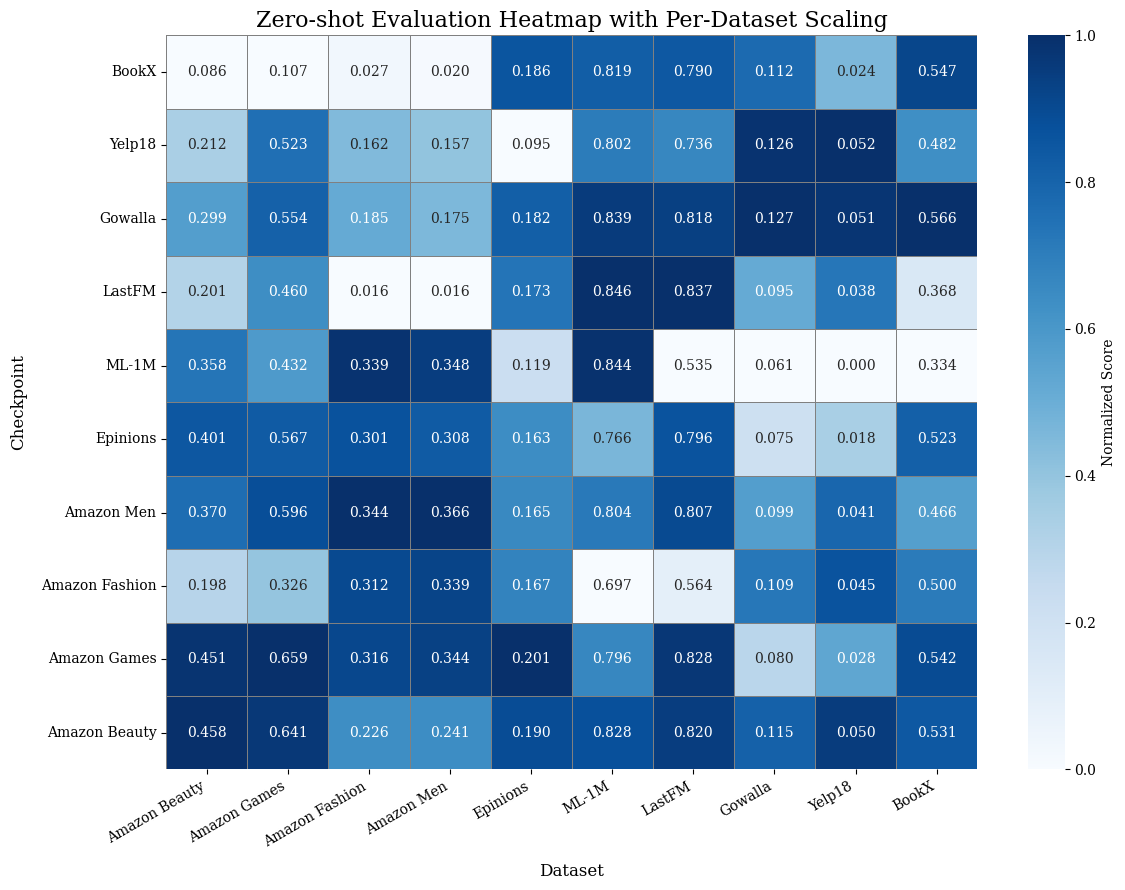

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV into a DataFrame
CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/results_heat_map_updated.csv"
df = pd.read_csv(CSV_FILE)
plot_path = '/itet-stor/trachsele/net_scratch/tl4rec/report_data/heatmap_updated.png'
# Use a serif font for better LaTeX compatibility
plt.rcParams["font.family"] = "serif"

# Rename dataset and checkpoint labels
def rename_dataset(name):
    if name == "Ml1m":
        return "ML-1M"
    elif name.startswith("Amazon_"):
        return name.replace("_", " ")
    elif name == "Yelp":
        return "Yelp18"
    return name

df["dataset"] = df["dataset"].apply(rename_dataset)
df["ckpt"] = df["ckpt"].str.replace(".pth", "", regex=False).apply(rename_dataset)

# Select the correct metric
def get_target_metric(row):
    return row["test_ndcg@20"] if row["dataset"] in ["Gowalla", "Yelp18"] else row["test_hits@10"]

df["target_metric"] = df.apply(get_target_metric, axis=1)

# Normalize target_metric per dataset **before pivoting**
df["normalized_target_metric"] = df.groupby("dataset")["target_metric"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

# Define dataset order (x-axis stays as before)
desired_order = ["Amazon Beauty", "Amazon Games", "Amazon Fashion", "Amazon Men", 
                 "Epinions", "ML-1M", "LastFM", "Gowalla", "Yelp18", "BookX"]

# Reverse the y-axis order (checkpoints)
reversed_order = desired_order[::-1]  # This reverses the list

# Pivot DataFrame for heatmap structure (ckpt as rows, dataset as columns)
pivot_original = df.pivot(index="ckpt", columns="dataset", values="target_metric")
pivot_normalized = df.pivot(index="ckpt", columns="dataset", values="normalized_target_metric")

# Apply ordering (x-axis normal, y-axis reversed)
pivot_original = pivot_original.reindex(index=reversed_order, columns=desired_order)
pivot_normalized = pivot_normalized.reindex(index=reversed_order, columns=desired_order)

# Plot the heatmap with Blue for 1.0 and White for 0.0
plt.figure(figsize=(12, 9))
ax = sns.heatmap(pivot_normalized, annot=pivot_original, fmt=".3f", cmap="Blues",
                 linewidths=0.7, linecolor="gray", cbar_kws={'label': 'Normalized Score'},
                 annot_kws={"size": 10}, vmin=0, vmax=1)

# Improve labels
plt.title("Zero-shot Evaluation Heatmap with Per-Dataset Scaling", fontsize=16)
plt.xlabel("Dataset", fontsize=12, labelpad=10)
plt.ylabel("Checkpoint", fontsize=12, labelpad=10)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# Save the plot
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
#plt.show()
# Save high-quality version
#plt.savefig("heatmap.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


pdfTeX 3.1415926-1.40.9-2.2 (Web2C 7.5.7)
kpathsea version 3.5.7
Copyright 2008 Peter Breitenlohner (eTeX)/Han The Thanh (pdfTeX).
Kpathsea is copyright 2008 Karl Berry and Olaf Weber.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Peter Breitenlohner (eTeX)/Han The Thanh (pdfTeX).
Kpathsea written by Karl Berry, Olaf Weber, and others.

Compiled with libpng 1.2.29; using libpng 1.2.29
Compiled with zlib 1.2.3; using zlib 1.2.3
Compiled with xpdf version 3.02pl2

This is dvipng 1.11 Copyright 2002-2008 Jan-Ake Larsson
dvipng 1.11
kpathsea version 3.5.7
Compiled with Freetype 2.3.7
Using libft 2.3.7
Using t1lib 5.0.2
Copyright (C) 2002-2008 Jan-Ake Larsson.
There is NO warranty.  You may redistribute this software
under the terms of the GNU Lesser General Public Licens

0

In [6]:
# generate best results
import sqlite3
import pandas as pd

# File and datasets list
DB_FILE = "//itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results.db" 
DATASETS = [
    "Epinions", "LastFM", "BookX", "Ml1m", "Gowalla",
    "Amazon_Beauty", "Amazon_Fashion", "Amazon_Men", "Amazon_Games", "Yelp18"
]
CSV_FILE = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/best_results.csv"

# Connect to the database and load the experiments table
conn = sqlite3.connect(DB_FILE)
df = pd.read_sql("SELECT * FROM experiments", conn)
conn.close()

# Filter for experiments corresponding to zero-shot (epochs=0) and fine tuning (epochs=1)
filtered_df = df[df['epochs'].isin([0, 1])]

# Exclude rows where the checkpoint is simply the dataset checkpoint (e.g. "LastFM.pth" for LastFM)
filtered_df = filtered_df[~filtered_df.apply(lambda row: row['ckpt'] == f"{row['dataset']}.pth", axis=1)]

# List to collect the best result for each dataset and epoch type
results_list = []

for ds in DATASETS:
    ds_df = filtered_df[filtered_df['dataset'] == ds]
    if ds_df.empty:
        continue  # Skip if no experiments exist for this dataset
    # Choose the metric: test_ndcg@20 for Gowalla and Yelp18, else test_hits@10
    metric = "test_ndcg@20" if ds in ["Gowalla", "Yelp18"] else "test_hits@10"
    
    for epoch in [0, 1]:
        epoch_df = ds_df[ds_df['epochs'] == epoch]
        if not epoch_df.empty:
            # Sort by the chosen metric in descending order and take the best (top 1) entry
            best_entry = epoch_df.sort_values(by=metric, ascending=False).head(1)
            results_list.append(best_entry)

# Concatenate all the best entries
final_results = pd.concat(results_list)

# Save the results to the CSV file
final_results.to_csv(CSV_FILE, index=False)

# Optionally, print the results
print(final_results)


                        ckpt         dataset  epochs      bpe   FT   valid_mr  \
128        Amazon_Beauty.pth        Epinions     0.0   5130.0  0.0        NaN   
153               LastFM.pth        Epinions     1.0   5130.0  0.0        NaN   
199         Amazon_Games.pth          LastFM     0.0    763.0  0.0        NaN   
206   Men_Epin_Gowa_Book.pth          LastFM     1.0    763.0  0.0        NaN   
177        Amazon_Beauty.pth           BookX     0.0   5314.0  0.0        NaN   
339            Beau_Epin.pth           BookX     1.0   5314.0  0.0        NaN   
102       Amazon_Fashion.pth            Ml1m     0.0   7012.0  0.0        NaN   
122              Gowalla.pth            Ml1m     1.0   7012.0  0.0        NaN   
245   Men_Epin_Gowa_Book.pth         Gowalla     0.0  13702.0  0.0        NaN   
275                 Ml1m.pth         Gowalla     1.0  13702.0  0.0        NaN   
4           Amazon_Games.pth   Amazon_Beauty     0.0   5652.0  0.0  23.250067   
299       Beau_Epin_Book.pth

In [9]:
import pandas as pd

# -----------------------------
# File paths (adjust these paths as needed)
best_csv_file = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/best_results.csv"
final_csv_file = "/itet-stor/trachsele/net_scratch/tl4rec/report_data/final_results.csv"

# Define the database file paths
GRUTL_DB_FILE = "//itet-stor/trachsele/net_scratch/tl4rec/model_outputs/results.db"
NBFNET_DB_FILE = "//itet-stor/trachsele/net_scratch/tl4rec/model_outputs/result.db"

# Load the 'experiments' table from GRUTL database
with sqlite3.connect(GRUTL_DB_FILE) as conn:
    grutl_df = pd.read_sql_query("SELECT * FROM experiments", conn)

# Load the 'results' table from NBFNET database
with sqlite3.connect(NBFNET_DB_FILE) as conn:
    nbfnet_df = pd.read_sql_query("SELECT * FROM results", conn)


# -----------------------------
# Load the CSV files
best_df = pd.read_csv(best_csv_file)


# -----------------------------
# Define the renaming function for datasets
def rename_dataset(name):
    if name == "Ml1m":
        return "ML-1M"
    elif name.startswith("Amazon_"):
        return name.replace("_", " ")
    elif name == "Yelp":
        return "Yelp18"
    return name

# Define the checkpoint abbreviation dictionary
checkpoint_abbr = {
    "Beau_Epin.pth": "AB-Epi",
    "Beau_Epin_Book_Game.pth": "AB-Epi-Bx-AG",
    "Men_Epin_Gowa_Book.pth": "AM-Epi-Gw-Bx",
    "Beau_Epin_Book.pth": "AB-Epi-Bx",
    "Beauty_Games_tuned.pth": "AB-AG",
    "inionsBeautyMl1m.pth": "Epi-AB-M1",
    "Amazon Beauty.pth": "AB",
    "Amazon Games.pth": "AG",
    "Amazon Fashion.pth": "AF",
    "Amazon Men.pth": "AM",
    "Epinions.pth": "Epi",
    "ML-1M.pth": "M1",
    "LastFM.pth": "LF",
    "Gowalla.pth": "Gw",
    "Yelp18.pth": "Yp",
    "BookX.pth": "Bx"
}

# -----------------------------
# Helper function to select the correct ndcg column based on dataset
def select_ndcg(row):
    # if dataset is Gowalla or Yelp18, use test_ndcg@20; otherwise test_ndcg@10
    if row["dataset"] in ["Gowalla", "Yelp18"]:
        return row.get("test_ndcg@20", None)
    else:
        return row.get("test_ndcg@10", None)

# -----------------------------
# Create a list to gather our results DataFrames
result_dfs = []

# 1. SOTA results from GRUTL (ckpt == "SOTA")
sota_df = grutl_df[grutl_df["ckpt"] == "SOTA"].copy()
sota_df["model"] = "SOTA"
sota_df["Setting"] = "SOTA"
sota_df["Ndcg"] = sota_df.apply(select_ndcg, axis=1)
sota_df["Hits@1"] = sota_df["test_hits@1"]
sota_df["Hits@3"] = sota_df["test_hits@3"]
sota_df["Hits@10"] = sota_df["test_hits@10"]
sota_df = sota_df[["model", "Setting", "dataset", "ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]
result_dfs.append(sota_df)

# 2. End-to-End results for GRUTL (ckpt == "ETE")
ete_grutl_df = grutl_df[grutl_df["ckpt"] == "ETE"].copy()
ete_grutl_df["model"] = "GRUTL"
ete_grutl_df["Setting"] = "End-to-End"
ete_grutl_df["Ndcg"] = ete_grutl_df.apply(select_ndcg, axis=1)
ete_grutl_df["Hits@1"] = ete_grutl_df["test_hits@1"]
ete_grutl_df["Hits@3"] = ete_grutl_df["test_hits@3"]
ete_grutl_df["Hits@10"] = ete_grutl_df["test_hits@10"]
ete_grutl_df = ete_grutl_df[["model", "Setting", "dataset", "ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]
result_dfs.append(ete_grutl_df)

# End-to-End results for NBFnet (only for selected datasets)
ete_nbfnet_df = nbfnet_df[(nbfnet_df["dataset"].isin(["Epinions", "LastFM", "BookX", "Ml1m"])) &
                          (nbfnet_df["ckpt"] == "ETE")].copy()
ete_nbfnet_df["model"] = "NBFnet"
ete_nbfnet_df["Setting"] = "End-to-End"
ete_nbfnet_df["Ndcg"] = ete_nbfnet_df.apply(select_ndcg, axis=1)
ete_nbfnet_df["Hits@1"] = ete_nbfnet_df["test_hits@1"]
ete_nbfnet_df["Hits@3"] = ete_nbfnet_df["test_hits@3"]
ete_nbfnet_df["Hits@10"] = ete_nbfnet_df["test_hits@10"]
ete_nbfnet_df = ete_nbfnet_df[["model", "Setting", "dataset", "ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]
result_dfs.append(ete_nbfnet_df)

# 3. GRUTL 0-shot and FT results (ckpt == "Beau_Epin.pth", epochs 0 or 1)
gs_grutl_df = grutl_df[(grutl_df["ckpt"] == "Beau_Epin.pth") & 
                       (grutl_df["epochs"].isin([0, 1]))].copy()
gs_grutl_df["model"] = "GRUTL"
gs_grutl_df["Setting"] = gs_grutl_df["epochs"].apply(lambda x: "0-shot" if x == 0 else "FT")
gs_grutl_df["Ndcg"] = gs_grutl_df.apply(select_ndcg, axis=1)
gs_grutl_df["Hits@1"] = gs_grutl_df["test_hits@1"]
gs_grutl_df["Hits@3"] = gs_grutl_df["test_hits@3"]
gs_grutl_df["Hits@10"] = gs_grutl_df["test_hits@10"]
gs_grutl_df = gs_grutl_df[["model", "Setting", "dataset", "ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]
result_dfs.append(gs_grutl_df)

# 4. Best GRUTL results from best_results.csv (0-shot and FT best)
best_df_copy = best_df.copy()
best_df_copy["model"] = "GRUTL"
best_df_copy["Setting"] = best_df_copy["epochs"].apply(lambda x: "0-shot (best)" if x == 0 else ("FT (best)" if x == 1 else ""))
best_df_copy["Ndcg"] = best_df_copy.apply(select_ndcg, axis=1)
best_df_copy["Hits@1"] = best_df_copy["test_hits@1"]
best_df_copy["Hits@3"] = best_df_copy["test_hits@3"]
best_df_copy["Hits@10"] = best_df_copy["test_hits@10"]
best_df_copy = best_df_copy[["model", "Setting", "dataset", "ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]
result_dfs.append(best_df_copy)

# 5. NBFnet 0-shot and FT results (only for datasets ["Epinions", "LastFM", "BookX", "Ml1m"])
gs_nbfnet_df = nbfnet_df[(nbfnet_df["dataset"].isin(["Epinions", "LastFM", "BookX", "Ml1m"])) &
                         (nbfnet_df["ckpt"] == "Beau_Epin.pth") &
                         (nbfnet_df["epochs"].isin([0, 1]))].copy()
gs_nbfnet_df["model"] = "NBFnet"
gs_nbfnet_df["Setting"] = gs_nbfnet_df["epochs"].apply(lambda x: "0-shot" if x == 0 else "FT")
gs_nbfnet_df["Ndcg"] = gs_nbfnet_df.apply(select_ndcg, axis=1)
gs_nbfnet_df["Hits@1"] = gs_nbfnet_df["test_hits@1"]
gs_nbfnet_df["Hits@3"] = gs_nbfnet_df["test_hits@3"]
gs_nbfnet_df["Hits@10"] = gs_nbfnet_df["test_hits@10"]
gs_nbfnet_df = gs_nbfnet_df[["model", "Setting", "dataset", "ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]
result_dfs.append(gs_nbfnet_df)

# -----------------------------
# Concatenate all collected results
final_df = pd.concat(result_dfs, ignore_index=True)

# Round the metrics to 3 decimals
for col in ["Hits@1", "Hits@3", "Hits@10", "Ndcg"]:
    final_df[col] = final_df[col].round(3)

# Rename dataset values using rename_dataset function
final_df["Dataset"] = final_df["dataset"].apply(rename_dataset)

# Replace ckpt values with the abbreviations (if no match, the original value is kept)
final_df["Ckpt"] = final_df["ckpt"].map(checkpoint_abbr).fillna(final_df["ckpt"])

# Select and order the final columns
final_df = final_df[["model", "Setting", "Dataset", "Ckpt", "Hits@1", "Hits@3", "Hits@10", "Ndcg"]]

# Sort by Dataset, then model, then Setting
final_df = final_df.sort_values(by=["Dataset", "model", "Setting"])

# Save the final DataFrame to CSV
final_df.to_csv(final_csv_file, index=False)

print("Final results saved to:", final_csv_file)


Final results saved to: /itet-stor/trachsele/net_scratch/tl4rec/report_data/final_results.csv
